In [18]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

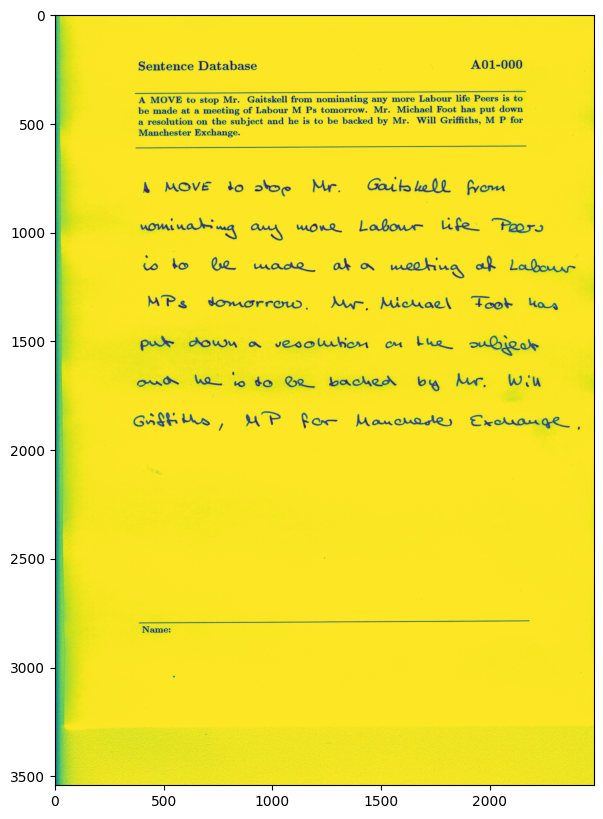

In [19]:
im = cv2.imread('data/000/a01-000u.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.imshow(im)

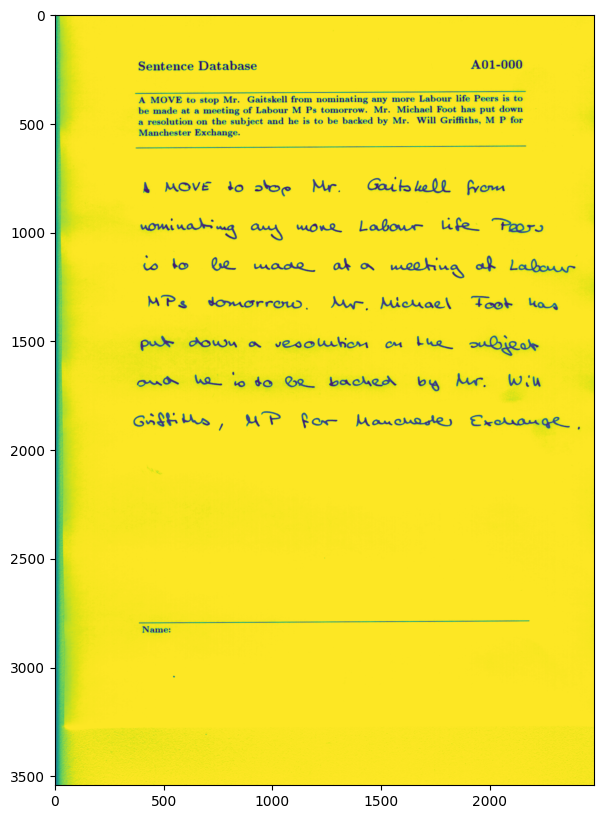

In [20]:
cv2.GaussianBlur(im, (5, 5), 0)
im = cv2.medianBlur(im, 5)

plt.figure(figsize=(10, 10))
plt.imshow(im)

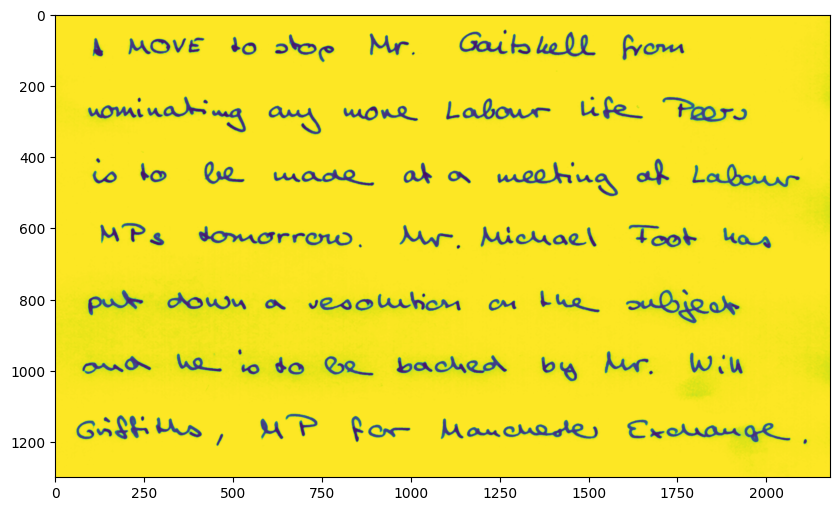

In [21]:
im = im[700:2000, 300:]
plt.figure(figsize=(10, 10))
plt.imshow(im)

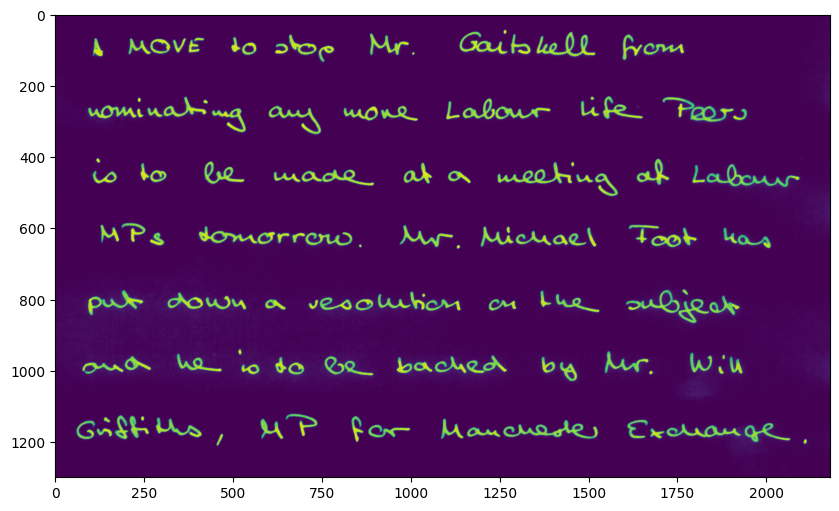

In [22]:
im = 255 - im
plt.figure(figsize=(10, 10))
plt.imshow(im)

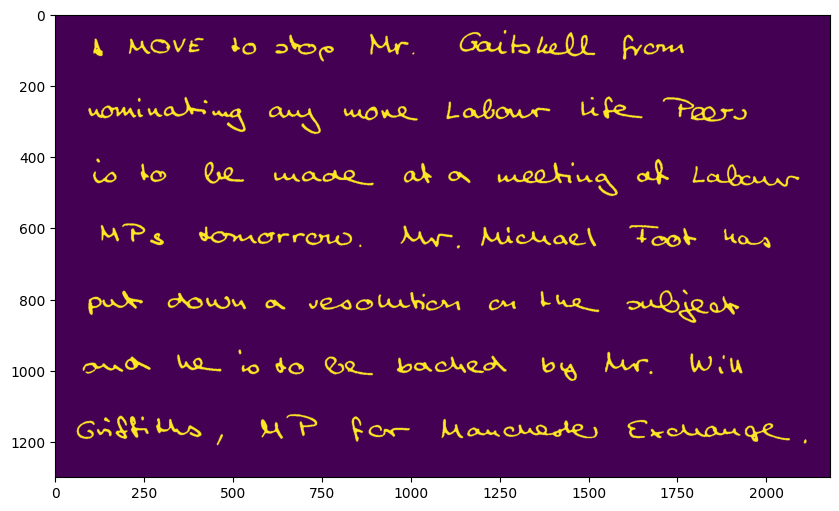

In [23]:
im = (im > 150).astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.imshow(im)

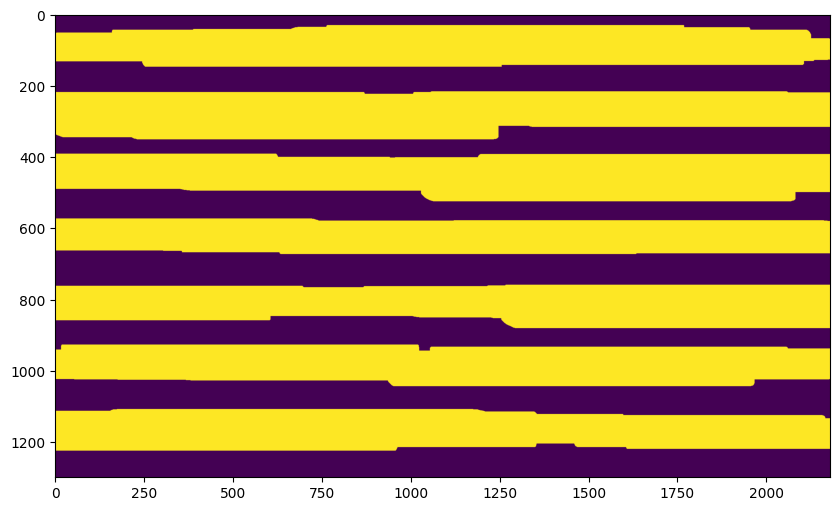

In [24]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1000, 30))
imd = cv2.dilate(im, kernel, iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(imd)

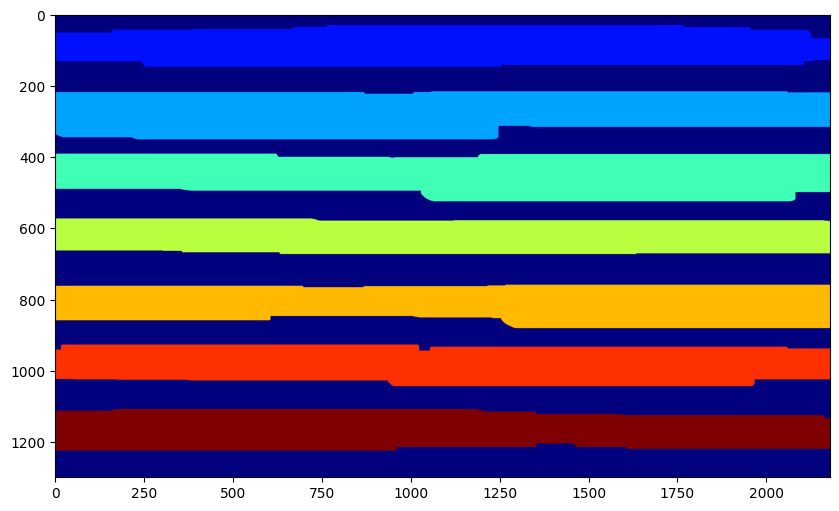

In [25]:
num_labels, labels_im = cv2.connectedComponents(imd)

plt.figure(figsize=(10, 10))
plt.imshow(labels_im, cmap='jet')

In [26]:
bounds = []
for label in range(1, num_labels):
    mask = (labels_im == label).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)
    x1, y1, x2, y2 = x, y, x + w, y + h
    bounds.append((x1, y1, x2, y2))

print(bounds)

[(0, 31, 2179, 148), (0, 217, 2179, 352), (0, 392, 2179, 526), (0, 574, 2179, 674), (0, 760, 2179, 882), (0, 928, 2179, 1045), (0, 1109, 2179, 1226)]


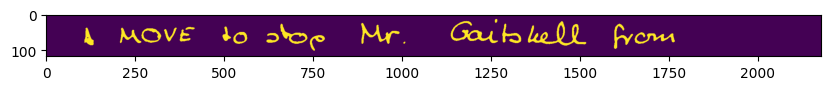

In [27]:
x1, y1, x2, y2 = bounds[0]
imr = im[y1:y2, x1:x2]
plt.figure(figsize=(10, 10))
plt.imshow(imr)

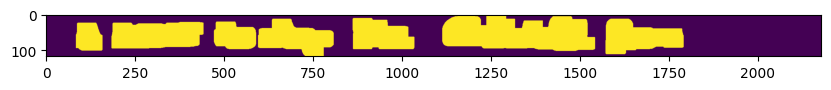

In [28]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 30))
imd = cv2.dilate(imr, kernel, iterations=1)
plt.figure(figsize=(10, 10))
plt.imshow(imd)

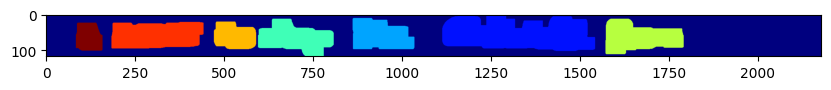

In [29]:
num_labels, labels_im = cv2.connectedComponents(imd)

plt.figure(figsize=(10, 10))
plt.imshow(labels_im, cmap='jet')

In [30]:
bounds = []
for label in range(1, num_labels):
    mask = (labels_im == label).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)
    x1, y1, x2, y2 = x, y, x + w, y + h
    bounds.append((x1, y1, x2, y2))

print(bounds)

[(1114, 0, 1544, 103), (862, 11, 1036, 98), (596, 13, 809, 117), (1573, 13, 1793, 112), (472, 21, 591, 98), (184, 22, 443, 96), (84, 24, 159, 102)]


In [31]:
bounds = sorted(bounds, key=lambda b: b[0])
print(bounds)

[(84, 24, 159, 102), (184, 22, 443, 96), (472, 21, 591, 98), (596, 13, 809, 117), (862, 11, 1036, 98), (1114, 0, 1544, 103), (1573, 13, 1793, 112)]


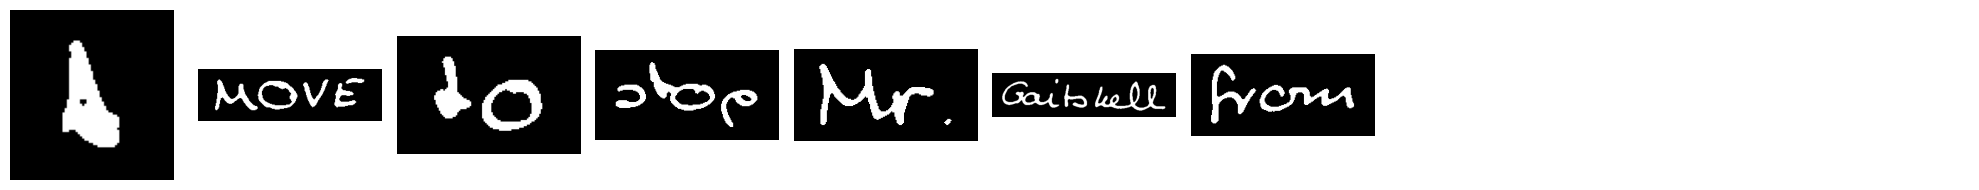

In [32]:
cols = 10
rows = (len(bounds) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
axes = axes.flatten()

for i, (x1, y1, x2, y2) in enumerate(bounds):
    axes[i].imshow(imr[y1:y2, x1:x2], cmap='gray')
    axes[i].axis('off')

# Hide any unused subplots
for i in range(len(bounds), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [33]:
import cv2
import numpy as np


def process_image_and_get_word_bounds(image_path, word_kernel_size=(50, 30), line_kernel_size=(1000, 30)):
    """
    Processes a grayscale image to extract word bounding boxes for all rows.

    Args:
        image_path (str): Path to the input image.
        word_kernel_size (tuple): Kernel size for word-level dilation.
        line_kernel_size (tuple): Kernel size for line-level dilation.

    Returns:
        list: A list of bounding boxes for all words in the format [(x1, y1, x2, y2), ...].
    """
    # Load the image in grayscale
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to smooth the image
    im = cv2.GaussianBlur(im, (5, 5), 0)

    # Apply median blur to remove noise
    im = cv2.medianBlur(im, 5)

    # Crop the region of interest
    im = im[700:2000, 300:]

    # Invert the image
    im = 255 - im

    # Threshold the image
    im = (im > 150).astype(np.uint8)

    # Line-level dilation
    line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, line_kernel_size)
    imd = cv2.dilate(im, line_kernel, iterations=1)

    # Connected components to find rows
    num_labels, labels_im = cv2.connectedComponents(imd)

    # Initialize a list to store all word bounds
    all_bounds = []

    # Process each row
    for label in range(1, num_labels):
        # Create a mask for the current row
        mask = (labels_im == label).astype(np.uint8)
        x, y, w, h = cv2.boundingRect(mask)
        row_im = im[y:y+h, x:x+w]

        # Word-level dilation
        word_kernel = cv2.getStructuringElement(
            cv2.MORPH_RECT, word_kernel_size)
        word_imd = cv2.dilate(row_im, word_kernel, iterations=1)

        # Connected components to find words
        num_word_labels, word_labels_im = cv2.connectedComponents(word_imd)

        # Extract word bounding boxes
        row_bounds = []
        for word_label in range(1, num_word_labels):
            word_mask = (word_labels_im == word_label).astype(np.uint8)
            wx, wy, ww, wh = cv2.boundingRect(word_mask)
            # Adjust coordinates to the original image
            row_bounds.append((x + wx, y + wy, x + wx + ww, y + wy + wh))

        # Sort words within the row by x-coordinate
        row_bounds = sorted(row_bounds, key=lambda b: b[0])

        # Extend the all_bounds list with the sorted row bounds
        all_bounds.extend(row_bounds)

    return all_bounds


# Example usage
bounds = process_image_and_get_word_bounds('data/000/a01-000u.png')
print(bounds)

[(85, 55, 159, 133), (184, 53, 442, 127), (473, 52, 590, 129), (596, 45, 809, 148), (863, 42, 1035, 129), (1115, 31, 1544, 133), (1573, 45, 1793, 143), (71, 220, 560, 346), (578, 245, 772, 351), (789, 245, 1044, 314), (1077, 224, 1417, 310), (1456, 218, 1676, 308), (1686, 220, 1969, 317), (84, 392, 198, 490), (218, 407, 337, 486), (397, 401, 556, 491), (593, 424, 921, 496), (958, 405, 1193, 490), (1222, 403, 1606, 525), (1613, 394, 1751, 493), (1769, 409, 2117, 499), (105, 574, 330, 664), (382, 584, 886, 669), (949, 581, 1163, 673), (1174, 584, 1546, 667), (1591, 579, 1828, 669), (1857, 590, 2036, 671), (70, 763, 272, 859), (293, 770, 562, 843), (568, 788, 673, 844), (691, 767, 1165, 847), (1197, 788, 1321, 847), (1342, 765, 1555, 852), (1584, 760, 1948, 882), (54, 948, 294, 1024), (320, 943, 493, 1018), (492, 929, 724, 1026), (735, 948, 919, 1029), (938, 946, 1294, 1022), (1346, 951, 1492, 1044), (1524, 936, 1705, 1026), (1763, 940, 1957, 1025), (38, 1114, 496, 1225), (555, 1110, 762,

[(85, 55, 159, 133), (184, 53, 442, 127), (473, 52, 590, 129), (596, 45, 809, 148), (863, 42, 1035, 129), (1115, 31, 1544, 133), (1573, 45, 1793, 143), (71, 220, 560, 346), (578, 245, 772, 351), (789, 245, 1044, 314), (1077, 224, 1417, 310), (1456, 218, 1676, 308), (1686, 220, 1969, 317), (84, 392, 198, 490), (218, 407, 337, 486), (397, 401, 556, 491), (593, 424, 921, 496), (958, 405, 1193, 490), (1222, 403, 1606, 525), (1613, 394, 1751, 493), (1769, 409, 2117, 499), (105, 574, 330, 664), (382, 584, 886, 669), (949, 581, 1163, 673), (1174, 584, 1546, 667), (1591, 579, 1828, 669), (1857, 590, 2036, 671), (70, 763, 272, 859), (293, 770, 562, 843), (568, 788, 673, 844), (691, 767, 1165, 847), (1197, 788, 1321, 847), (1342, 765, 1555, 852), (1584, 760, 1948, 882), (54, 948, 294, 1024), (320, 943, 493, 1018), (492, 929, 724, 1026), (735, 948, 919, 1029), (938, 946, 1294, 1022), (1346, 951, 1492, 1044), (1524, 936, 1705, 1026), (1763, 940, 1957, 1025), (38, 1114, 496, 1225), (555, 1110, 762,

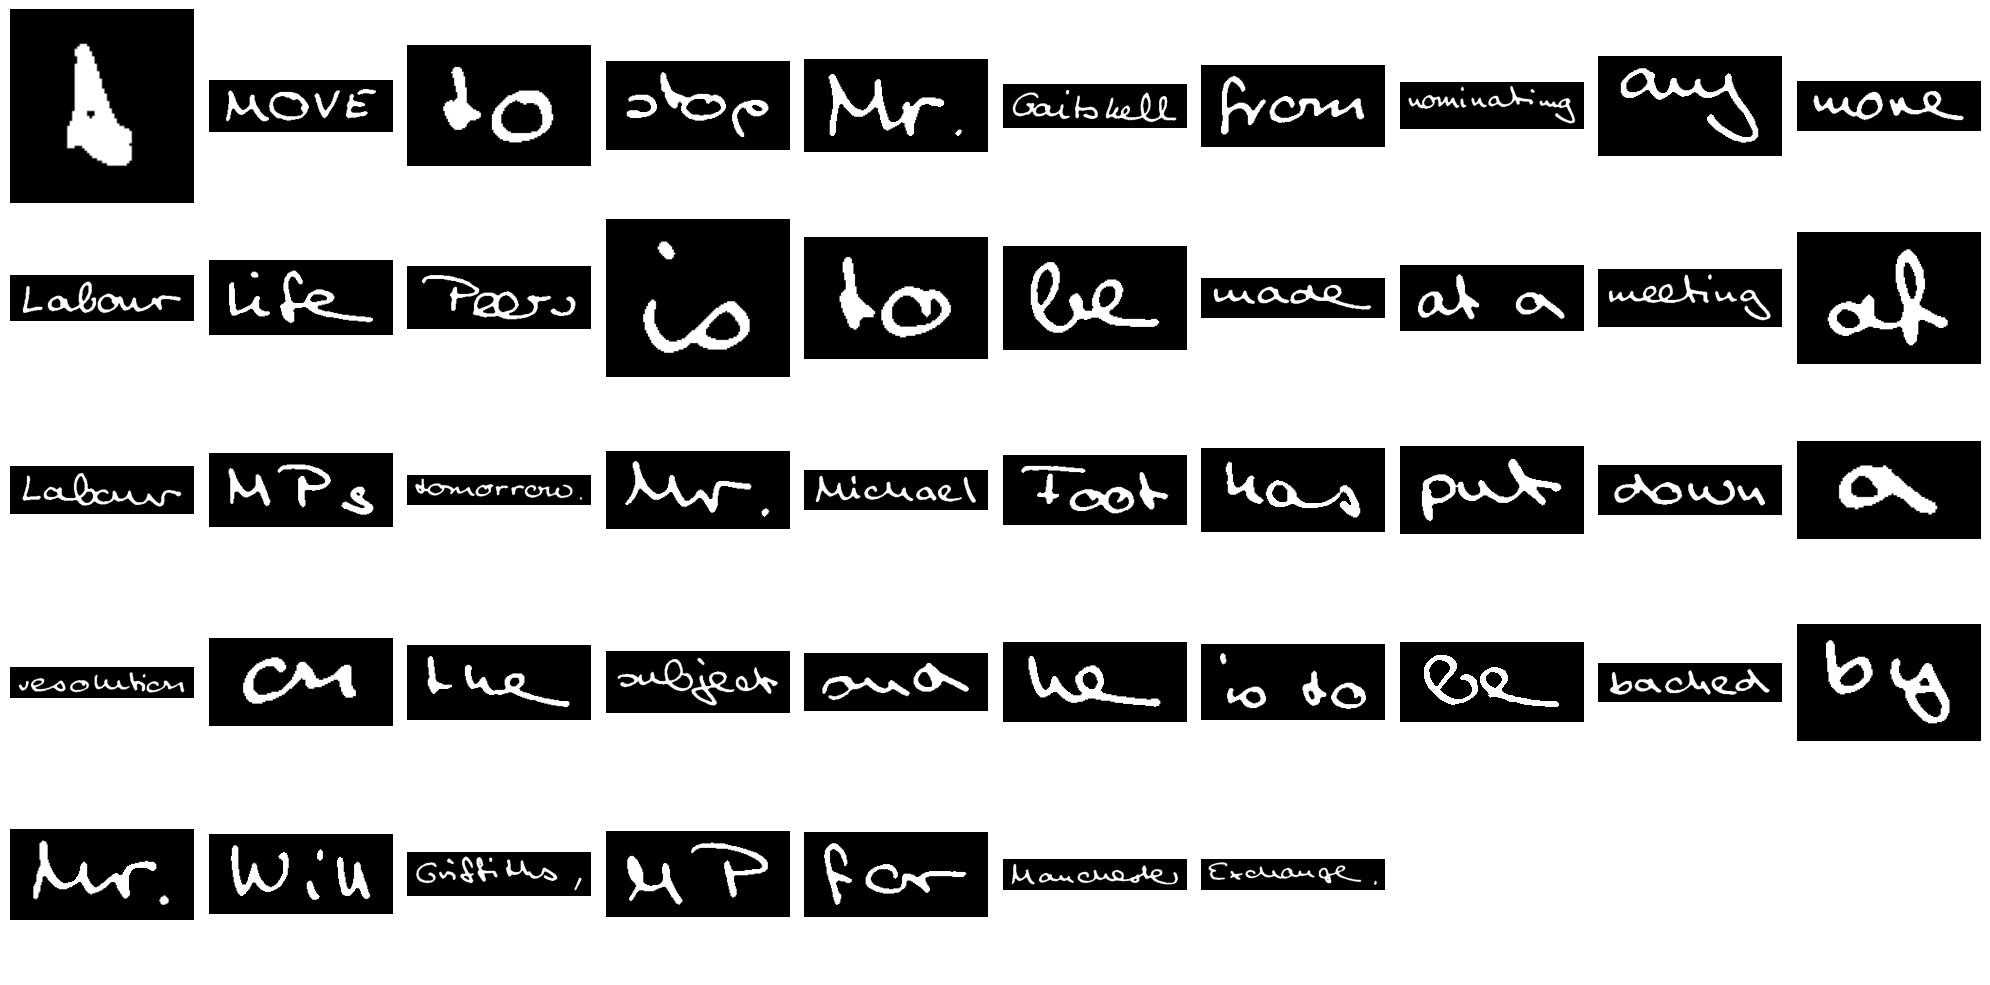

In [34]:
# Example usage
bounds = process_image_and_get_word_bounds('data/000/a01-000u.png')
print(bounds)

cols = 10
rows = (len(bounds) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
axes = axes.flatten()

for i, (x1, y1, x2, y2) in enumerate(bounds):
    axes[i].imshow(im[y1:y2, x1:x2], cmap='gray')
    axes[i].axis('off')

# Hide any unused subplots
for i in range(len(bounds), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

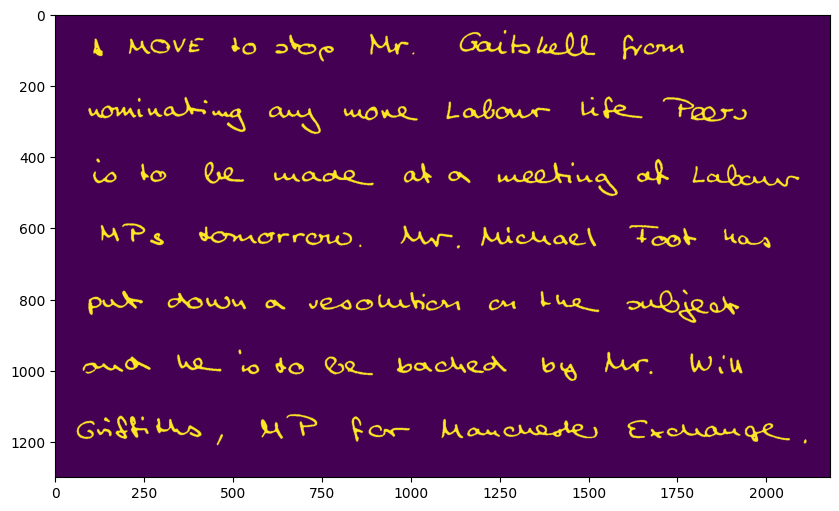

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.show()